In [1]:
import jax.numpy as np
from jax import grad, value_and_grad, jit, ops

import matplotlib.pyplot as plt
%matplotlib inline 

import SSN_classes
import SSN_power_spec
import gamma_SSN_losses as losses

from importlib import reload
reload(SSN_classes)
reload(SSN_power_spec)
reload(losses)

<module 'gamma_SSN_losses' from '/Users/cholt/Google Drive/Python/torch_SSN/jax_caleb/gamma_SSN_losses.py'>

In [2]:
#the constant (non-optimized) parameters:

#fixed point algorithm:
dt = 1
xtol = 1e-6
Tmax = 500

#power spectrum resolution and range
fnums = 30
freq_range = [15,100]

#SSN parameters
n = 2
k = 0.04
tauE = 20 # in ms
tauI = 10 # in ms
psi = 0.774

t_scale = 1
tau_s = np.array([3, 5, 100])*t_scale #in ms, AMPA, GABA, NMDA current decay time constants
# NMDAratio = 0.4 #NMDA strength as a fraction of E synapse weight

/Users/cholt/Google Drive/Python/torch_SSN/jax/jax/lib/xla_bridge.py:109: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [6]:
def ssn_PS(params, contrasts):
    #unpack parameters
    Jee = params[0]
    Jei = params[1]
    Jie = params[2]
    Jii = params[3]
    
    if len(params) < 6:
        i2e = params[4]
        gE = 1
        gI = 1
        NMDAratio = 0.4
    else:
        i2e = 1
        gE = params[4]
        gI = params[5]
        NMDAratio = params[6]
    
    
    cons = len(contrasts)

    J2x2 = np.array([[Jee, -Jei], [Jie,  -Jii]]) * np.pi * psi #np.array([[2.5, -1.3], [2.4,  -1.0]]) * np.pi * psi
    ssn = SSN_classes.SSN_2D_AMPAGABA(tau_s, NMDAratio, n,k,tauE,tauI, *np.abs(J2x2).ravel())
    
    r_init = np.zeros([ssn.N, len(contrasts)])
    inp_vec = np.array([[gE], [gI*i2e]]) * contrasts
    
    r_fp = ssn.fixed_point_r(inp_vec, r_init=r_init, Tmax=Tmax, dt=dt, xtol=xtol)
    
    spect, fs, _ = SSN_power_spec.linear_PS_sameTime(ssn, r_fp, SSN_power_spec.NoisePars(), freq_range, fnums, cons)
    
    return spect, fs, r_fp


#@jit
def loss(params):
    contrasts = np.array([0, 25, 50, 100])
    spect, fs, r_fp = ssn_PS(params, contrasts)
    
    if np.max(np.abs(np.imag(spect))) > 0.01:
        print("Spectrum is dangerously imaginary")
    
#     spect_loss = losses.loss_spect_contrasts(fs, np.real(spect))
#     rates_loss = losses.loss_rates_contrasts(r_fp)
#     param_loss = losses.loss_params(params)
    
    half_width_rates = 20 # basin around acceptable rates 
    kink_control = 5 # how quickly log(1 + exp(x)) goes to ~x, where x = target_rates - found_rates
    
    prefact_rates = 5
    prefact_params = 10
    
    spect_loss = losses.loss_spect_contrasts(fs, np.real(spect))
    rates_loss = prefact_rates * losses.loss_rates_contrasts(r_fp, half_width_rates, kink_control) #fourth arg is slope which is set to 1 normally
    param_loss = prefact_params * losses.loss_params(params)
    
    
    if spect_loss/rates_loss < 1:
        print('rates loss is greater than spect loss')
#     print(spect_loss/rates_loss) 
    
    return spect_loss + rates_loss + param_loss
#         return losses.loss_SSN_2D_contrast(fs, np.real(spect))
        
#         return losses.loss_SSN_2D_contrast(fs, np.real(spect))




# def ssn_PS_v(params, contrasts):
#     #unpack parameters
#     Jee = params[0]
#     Jei = params[1]
#     Jie = params[2]
#     Jii = params[3]
#     i2e = params[4]

#     J2x2 = np.array([[Jee, -Jei], [Jie,  -Jii]]) * np.pi * psi #np.array([[2.5, -1.3], [2.4,  -1.0]]) * np.pi * psi
#     ssn = SSN_classes.SSN_2D_AMPAGABA(tau_s, NMDAratio, n,k,tauE,tauI, *np.abs(J2x2).ravel())
    
#     spect = []
#     v_init = np.zeros(ssn.dim)
#     for con in contrasts:
#         inp_vec = np.array([1,i2e]) * con
#         v_fp = ssn.fixed_point(inp_vec, x_init=v_init, Tmax=Tmax, dt=dt, xtol=xtol)
#         v_init = v_fp
#         r_fp = ssn.powlaw( v_fp.reshape((ssn.num_rcpt, ssn.N)).sum(axis=0) )

#         powspecE, fs, _ = SSN_power_spec.linear_power_spect(ssn, r_fp, SSN_power_spec.NoisePars(), freq_range=freq_range, fnums=fnums)
#         spect.append(powspecE)
    
#     spect = np.array(spect).T
#     return spect, fs

      converged to fixed point at iter=207,      as max(abs(dx./max(xvec,1.0))) < 1e-06 
run time: 0.7804112434387207


/Users/cholt/miniconda3/envs/juC/lib/python3.7/site-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0.5, 0, 'frequency (Hz)')

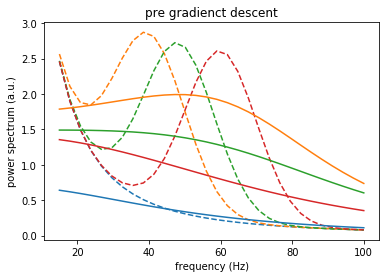

In [7]:
params_init = np.array([2.5, 1.3, 2.4,  1.0, 1.0]) # [Jee, Jei, Jie, Jii, i2e]
# params_init = np.array([1.7, 1.25, 2.2,  1.5, 1.2]) # [Jee, Jei, Jie, Jii, i2e]
params_init = np.array([2.5, 1.3, 2.4, 1.0, 1.0, 1.0, 0.6])
test_contrasts = np.array([0, 25, 50, 100])

import time
t0 = time.time()
spect, fs, r_fp = ssn_PS(params_init, test_contrasts)
tt = time.time()-t0
print("run time:", tt)

target_PS = losses.get_target_spect(fs)


fig, ax = plt.subplots(1,1)
ax.plot(fs, target_PS, "--")
ax.set_prop_cycle(None)
ax.plot(fs, spect/np.mean(spect))
ax.set_title('pre gradienct descent')
ax.set_ylabel('power spectrum (a.u.)')
ax.set_xlabel('frequency (Hz)')

# Run Gradient Descent

In [8]:
#dloss = grad(loss)
dloss = value_and_grad(loss)

gd_iters = 10
eta = .001 #learning rate

params = params_init
loss_t = []
t0 = time.time()
for ii in range(gd_iters):
    print("G.D. step ", ii+1)
    L, dL = dloss(params)
    params = params - eta * dL #dloss(params)
    loss_t.append(L)

print("{} GD steps took {} seconds.".format(gd_iters, time.time()-t0))
if len(params) < 6:
    print("fit [Jee, Jei, Jie, Jii, i2e] = ", params)
else:
    print("fit [Jee, Jei, Jie, Jii, gE, gI, NMDAratio] = ", params)

G.D. step  1
      converged to fixed point at iter=207,      as max(abs(dx./max(xvec,1.0))) < 1e-06 


/Users/cholt/Google Drive/Python/torch_SSN/jax/jax/lax/lax.py:328: ComplexWarning: Casting complex values to real discards the imaginary part
  warnings.warn(msg, onp.ComplexWarning)


G.D. step  2
      converged to fixed point at iter=216,      as max(abs(dx./max(xvec,1.0))) < 1e-06 
G.D. step  3
      converged to fixed point at iter=221,      as max(abs(dx./max(xvec,1.0))) < 1e-06 
G.D. step  4
      converged to fixed point at iter=227,      as max(abs(dx./max(xvec,1.0))) < 1e-06 
G.D. step  5
      converged to fixed point at iter=233,      as max(abs(dx./max(xvec,1.0))) < 1e-06 
G.D. step  6
      converged to fixed point at iter=237,      as max(abs(dx./max(xvec,1.0))) < 1e-06 
G.D. step  7
      converged to fixed point at iter=241,      as max(abs(dx./max(xvec,1.0))) < 1e-06 
G.D. step  8
      converged to fixed point at iter=245,      as max(abs(dx./max(xvec,1.0))) < 1e-06 
G.D. step  9
      converged to fixed point at iter=249,      as max(abs(dx./max(xvec,1.0))) < 1e-06 
G.D. step  10
      converged to fixed point at iter=253,      as max(abs(dx./max(xvec,1.0))) < 1e-06 
10 GD steps took 41.86254405975342 seconds.
fit [Jee, Jei, Jie, Jii, gE, gI, NMDA

      converged to fixed point at iter=256,      as max(abs(dx./max(xvec,1.0))) < 1e-06 


Text(0.5, 0, 'frequency (Hz)')

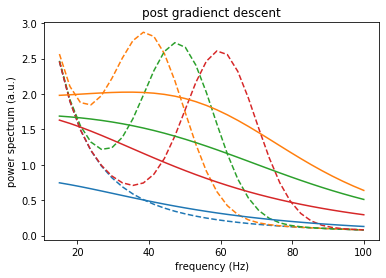

In [9]:
spect, fs, r_fp = ssn_PS(params, test_contrasts)
spect = spect/np.mean(spect)

fig, ax = plt.subplots(1,1)
ax.plot(fs, target_PS, "--")
#colrs = ax.get_color_cycle()
ax.set_prop_cycle(None)
ax.plot(fs, spect)
ax.set_title('post gradienct descent')
ax.set_ylabel('power spectrum (a.u.)')
ax.set_xlabel('frequency (Hz)')

In [11]:
half_width_rates = 20 # basin around acceptable rates 
kink_control = 5 

print(losses.loss_rates_contrasts(r_fp, half_width_rates, kink_control))
print(losses.loss_params(params))
print(losses.loss_spect_contrasts(fs, np.real(spect)))

0.037330657
0.0
0.49420977


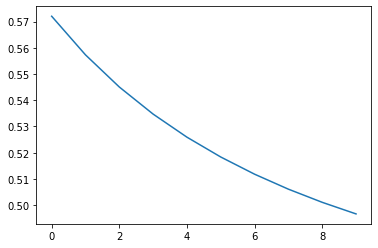

In [26]:
plt.plot(loss_t)

In [26]:
r_fp

DeviceArray([[ 0.       ,  3.77882338,  3.36183238,  1.48500228],
             [ 0.       , 12.13152695, 19.44856262, 32.70176697]],
            dtype=float32)

In [10]:
2 + np.tanh((tar_r - r_fp - 20)/5) - np.tanh((tar_r - r_fp + 20)/5)

NameError: name 'tar_r' is not defined

In [43]:
np.mean(losses.rates_error_fcn(r_fp, 20, 5, 4))

DeviceArray(0.35550666, dtype=float32)

In [25]:
r_fp

DeviceArray([[ 0.       ,  6.63384628, 12.79779148, 22.66216278],
             [ 0.       , 13.01011848, 27.97024918, 55.88973999]],
            dtype=float32)

In [2]:
params

NameError: name 'params' is not defined

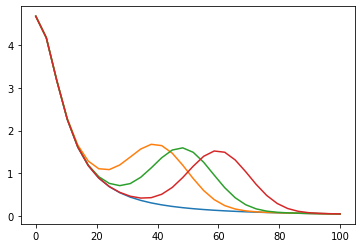

Text(0.5, 0, 'Contrast')

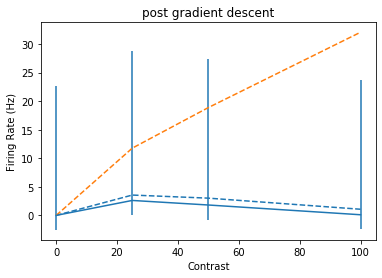

In [156]:
target_rates = losses.get_target_rates()
rates_error = target_rates - r_fp
# lower_bound_rates = losses.myReLu(half_width_rates/kink_control)
# upper_bound_rates = losses.myReLu(-half_width_rates/kink_control)

fig_rates, ax_rates = plt.subplots(1,1)
ax_rates.plot(test_contrasts, target_rates.T, "--")
#colrs = ax.get_color_cycle()
ax_rates.set_prop_cycle(None)
# ax_rates.plot(test_contrasts, r_fp.T)
ax_rates.set_prop_cycle(None)
# ax_rates.plot(test_contrasts, lower_bound_rates.T, '^')
# ax_rates.set_prop_cycle(None)
# ax_rates.plot(test_contrasts, upper_bound_rates.T, '^')
# ax_rates.errorbar(test_contrasts, r_fp[0,:].T, np.array([[upper_bound_rates[0,:]], [lower_bound_rates[0,:]]]) )
plt.errorbar(test_contrasts,r_fp[0,:], yerr=(e_error), fmt='')
ax_rates.set_title('post gradient descent')
ax_rates.set_ylabel('Firing Rate (Hz)')
ax_rates.set_xlabel('Contrast')

# plt.plot(test_contrasts,r_fp.T)

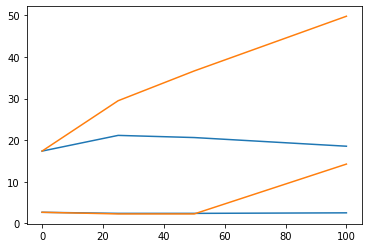

In [203]:
import numpy as onp

x = np.linspace(-30, 30, 10000)
cons = len(test_contrasts)
upper_bound_rates = onp.zeros((2, cons))
lower_bound_rates = onp.zeros((2, cons))


rates_range = np.linspace(-30, 100, 1000)
for ei in [0,1]:
    for con in np.arange(cons):
        error_range = target_rates[ei, con] - rates_range
        if target_rates[ei, con] - half_width_rates < 0:
            lower_half_width = target_rates[ei, con]
        else:
             lower_half_width = half_width_rates
        
        lower_curve = losses.myReLu((error_range - lower_half_width)/kink_control)
        higher_curve = losses.myReLu((-error_range - half_width_rates)/kink_control)
        
        upper_bound_rates[ei, con] = np.max(rates_range[higher_curve+lower_curve < 0.5])
        lower_bound_rates[ei, con] = np.min(rates_range[higher_curve+lower_curve < 0.5])

        

# upper_bound = losses.myReLu((error_range - half_width_rates)/kink_control)
# lower_bound = losses.myReLu((-error_range - half_width_rates)/kink_control)

e_error = np.vstack(([-lower_bound_rates[0,:]], [upper_bound_rates[0,:]])) 
i_error = np.vstack(([-lower_bound_rates[1,:]], [upper_bound_rates[1,:]])) 

# plt.plot(rates_range, upper_bound + lower_bound)
# plt.plot(x, yy)
fig, ax = plt.subplots(1,1)
ax.plot(test_contrasts, upper_bound_rates.T)
ax.set_prop_cycle(None)
ax.plot(test_contrasts, lower_bound_rates.T)


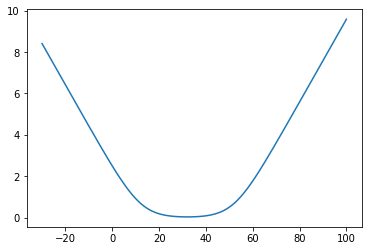

In [204]:
plt.plot(rates_range, lower_curve + higher_curve)

Text(0.5, 1.0, 'I Rates')

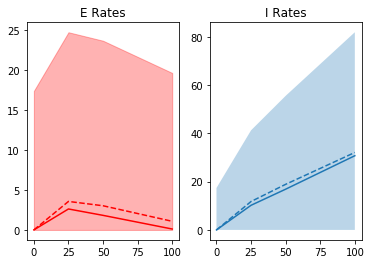

In [208]:
fig_split, (ax1, ax2) = plt.subplots(1,2)
ax1.plot(test_contrasts, target_rates[0,:], "r--")
ax1.set_prop_cycle(None)
ax1.plot(test_contrasts, r_fp[0,:],"r")
# ax1.fill_between(test_contrasts, r_fp[0,:] + e_error[1,:], r_fp[0,:] - np.abs(e_error[0,:]), color='r', alpha=0.3)
ax1.fill_between(test_contrasts, target_rates[0,:] + e_error[1,:], 0, color='r', alpha=0.3)
ax1.set_title('E Rates')

ax2.plot(test_contrasts, target_rates[1,:], "--")
ax2.set_prop_cycle(None)
ax2.plot(test_contrasts, r_fp[1,:])
# ax2.fill_between(test_contrasts, r_fp[1,:] + i_error[1,:], r_fp[1,:] - np.abs(i_error[0,:]), alpha=0.3)
ax2.fill_between(test_contrasts, target_rates[1,:] + i_error[1,:], 0, alpha=0.3)
ax2.set_title('I Rates')

In [196]:
r_fp[1,:]

DeviceArray([ 0.      , 10.20130444, 16.86116791, 30.71611214],
            dtype=float32)

In [190]:
r_fp[1,:]

DeviceArray([ 0.      , 10.20130444, 16.86116791, 30.71611214],
            dtype=float32)